In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
from math import sqrt 
import datetime
import warnings 
from pandas.plotting import scatter_matrix 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
training_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/testing.csv')

In [5]:
print(training_data.shape)
print(test_data.shape)

(14803, 32)
(4932, 32)


In [6]:
energy_data = pd.concat([training_data, test_data], ignore_index=True)
energy_data.shape
energy_data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [7]:
appliance_data = pd.DataFrame({'Date': energy_data.date,
                               'Appliances': energy_data.Appliances
                               }) 
appliance_data.Date = pd.to_datetime(appliance_data.Date)
appliance_data.set_index('Date', inplace=True)

In [8]:
appliance_data.head()

,Appliances
Date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:40:00,60
2016-01-11 17:50:00,50


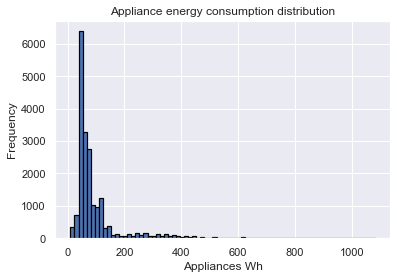

In [9]:
plt.hist(appliance_data.Appliances, bins=75, edgecolor='black', linewidth=1.2)
plt.rcParams["figure.figsize"] = (18,10)
plt.title('Appliance energy consumption distribution')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')
plt.show()

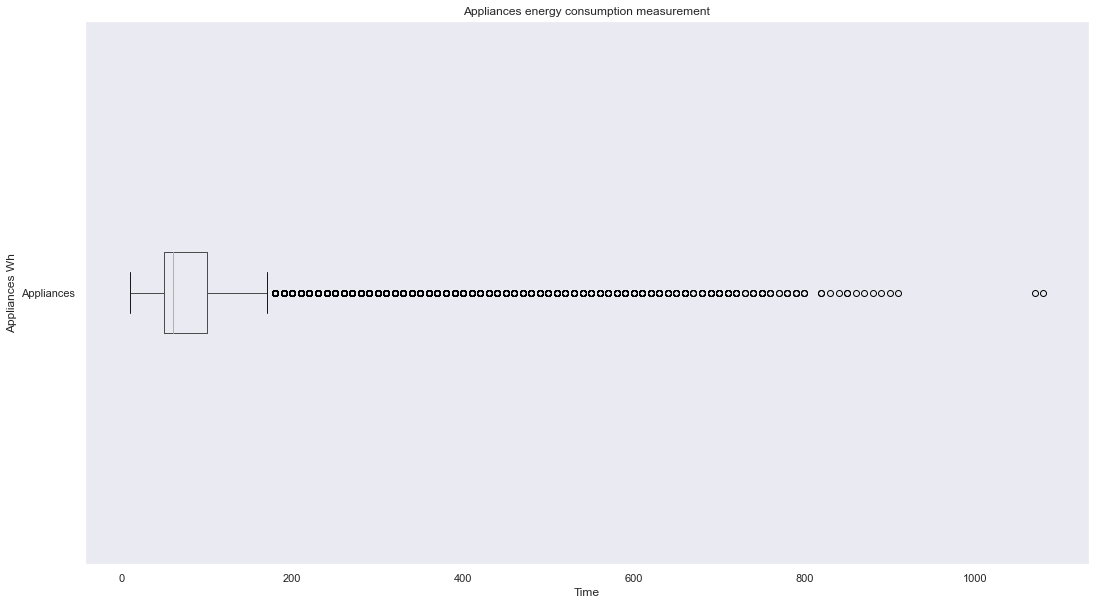

In [10]:
appliance_data.boxplot(vert=False)
plt.rcParams["figure.figsize"]=(18,10)
plt.grid()
plt.title('Appliances energy consumption measurement')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.show()

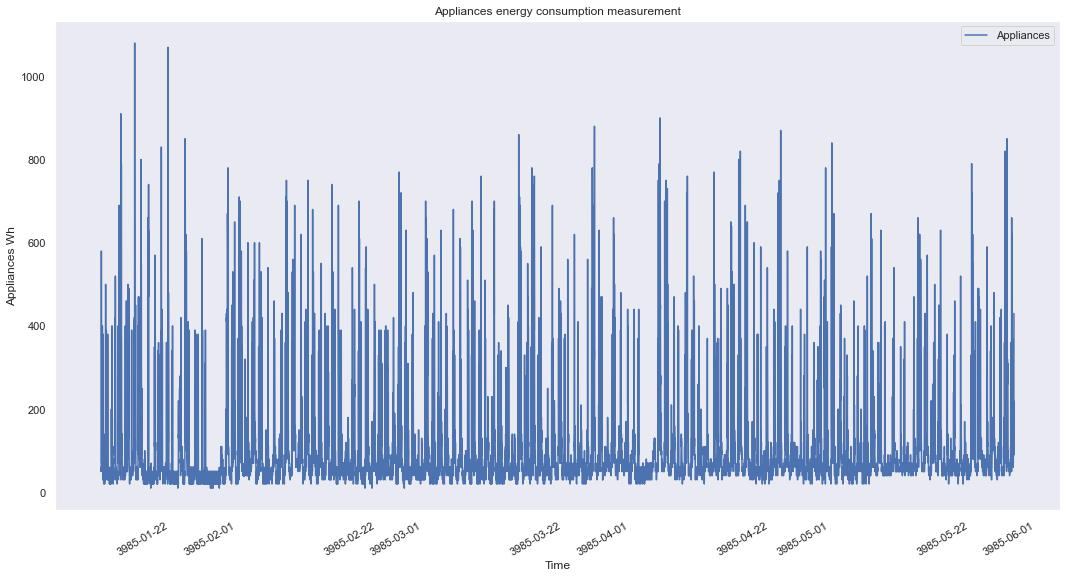

In [11]:
appliance_data.plot()
plt.rcParams["figure.figsize"] = (18,10)
plt.grid()
plt.title('Appliances energy consumption measurement')
plt.xlabel('Time')
plt.ylabel('Appliances Wh')
plt.show()

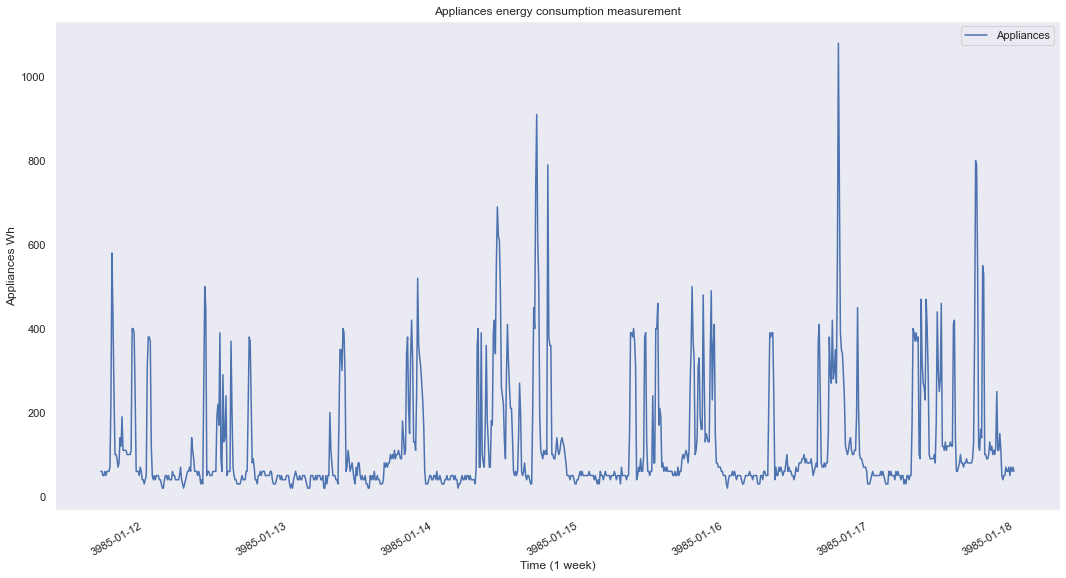

In [12]:
appliance_data['2016-01-11':'2016-01-17'].plot()
plt.rcParams["figure.figsize"] = (18,10)
plt.grid()
plt.title('Appliances energy consumption measurement')
plt.xlabel('Time (1 week)')
plt.ylabel('Appliances Wh')
plt.show()

In [13]:
train = training_data.drop(['date','Appliances','rv1','rv2', 'WeekStatus','Day_of_week'], axis=1)
test = test_data.drop(['date','Appliances','rv1','rv2', 'WeekStatus','Day_of_week'], axis=1)

In [14]:
train_half=train.join(pd.get_dummies(training_data.Day_of_week))
train_full=train_half.join(pd.get_dummies(training_data.WeekStatus))
train_full.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,NSM,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Weekday,Weekend
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,61200,0,1,0,0,0,0,0,1,0
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,61800,0,1,0,0,0,0,0,1,0
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,62400,0,1,0,0,0,0,0,1,0
3,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,63600,0,1,0,0,0,0,0,1,0
4,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,...,64200,0,1,0,0,0,0,0,1,0


In [15]:
test_half=test.join(pd.get_dummies(test_data.Day_of_week))
test_full=test_half.join(pd.get_dummies(test_data.WeekStatus))
test_full.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,NSM,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Weekday,Weekend
0,40,19.890000,46.066667,19.200000,44.590000,19.79,45.000000,18.89,45.723333,17.166667,...,63000,0,1,0,0,0,0,0,1,0
1,50,19.890000,45.766667,19.200000,44.500000,19.79,44.900000,18.89,45.790000,17.100000,...,64800,0,1,0,0,0,0,0,1,0
2,70,19.926667,45.863333,19.356667,44.400000,19.79,44.900000,18.89,46.430000,17.100000,...,67200,0,1,0,0,0,0,0,1,0
3,60,20.066667,46.396667,19.426667,44.400000,19.79,44.826667,19.00,46.430000,17.100000,...,67800,0,1,0,0,0,0,0,1,0
4,10,20.566667,53.893333,20.033333,46.756667,20.10,48.466667,19.00,48.490000,17.150000,...,70200,0,1,0,0,0,0,0,1,0


In [16]:
lr = linear_model.LinearRegression()

In [17]:
X_train = train_full
y_train = training_data.Appliances

In [18]:
X_test = test_full
y_test = test_data.Appliances

In [19]:
lr.fit(X_train,y_train)
y_predict = lr.predict(X_test)

In [20]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
print('RMSE: ', sqrt(mean_squared_error(y_test,y_predict)))
print('R2: ', r2_score(y_test,y_predict))
print('MAE: ', mean_absolute_error(y_test,y_predict))
print('MAPE: ', MAPE(y_test,y_predict))

RMSE:  93.17607638358446
R2:  0.1590135881301198
MAE:  51.97453623832876
MAPE:  59.93542814904307


In [23]:
rfe = RFE(estimator = lr, n_features_to_select = 34, step = 1)
rfe.fit(X_train, y_train)
y_hat_test = rfe.predict(X_test)

In [24]:
print('RMSE: ', sqrt(mean_squared_error(y_test,y_hat_test)))
print('R2: ', r2_score(y_test,y_hat_test))
print('MAE: ', mean_absolute_error(y_test,y_hat_test))
print('MAPE: ', MAPE(y_test,y_hat_test))

RMSE:  93.30457789162362
R2:  0.15669233688090334
MAE:  52.02879594435494
MAPE:  59.949151910515475


In [22]:
import scipy as sp 
from scipy import stats
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

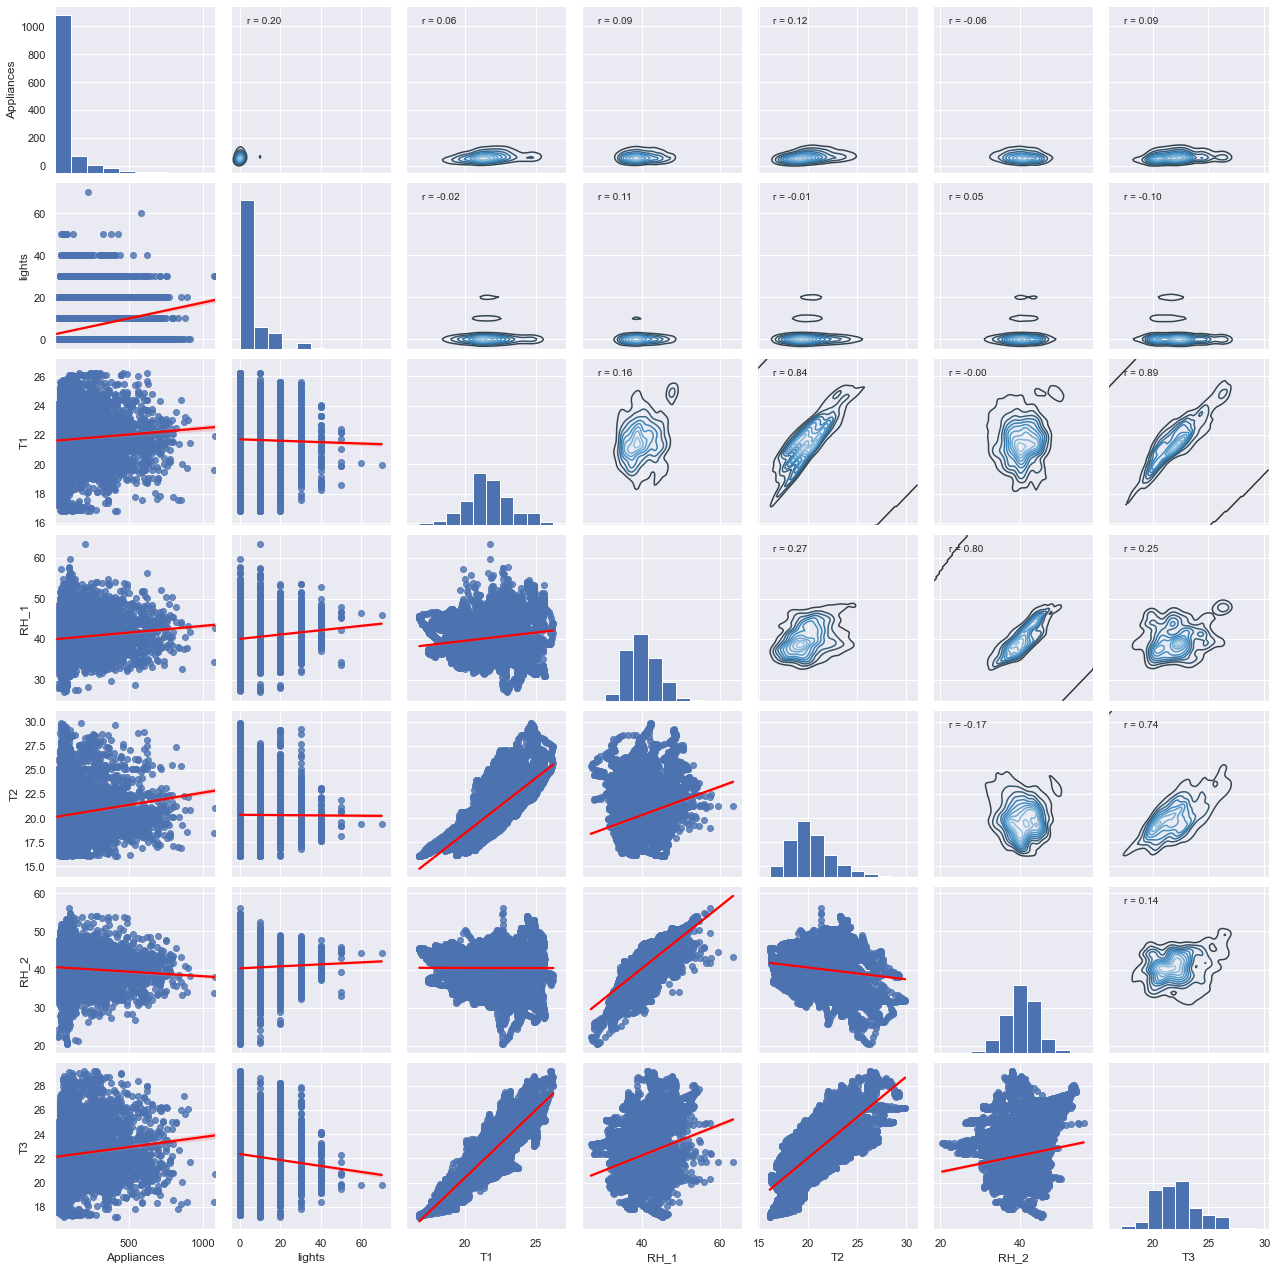

In [68]:
plots = energy_data[['Appliances','lights','T1','RH_1','T2','RH_2','T3']]

g = sns.PairGrid(plots)
g = g.map_lower(sns.regplot, line_kws={'color':'red'})
g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_upper(corrfunc)
g.map_upper(sns.kdeplot, cmap="Blues_d")